https://www.kaggle.com/hsankesara/image-captioning

In [1]:
import os
import tensorflow as tf
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import random
import pandas as pd
import re
from scipy.sparse import csr_matrix
from scipy.sparse import vstack
import tensorflow as tf

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
train_images_list = os.listdir('C:/Users/hskim/image_captioning_flickr2/flickr30k_images/flickr30k_images/flickr30k_images/')

In [3]:
sample_size = 30
train_images_list = train_images_list[:sample_size]

In [4]:
size = (256, 256)
num_channels = 3

In [5]:
train = np.array([None] * sample_size)
real_images = np.array([None] * sample_size)

In [6]:
j = 0
for i in train_images_list:
    real_images[j] = np.array(plt.imread('C:/Users/hskim/image_captioning_flickr2/flickr30k_images/flickr30k_images/flickr30k_images/' + i))
    train[j] = np.array(plt.imread('C:/Users/hskim/image_captioning_flickr2/flickr30k_images/flickr30k_images/flickr30k_images/' + i))
    j += 1

In [7]:
j = 0
for i in train:
    train[j] = cv2.resize(i, size)
    train[j] = train[j].reshape(1, size[0], size[1], num_channels)
    j += 1

In [8]:
train = np.vstack(train[:])

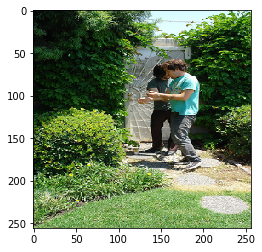

In [9]:
plt.imshow(np.squeeze(train[0]))
plt.show()

In [10]:
train_captions = pd.read_csv('C:/Users/hskim/image_captioning_flickr2/flickr30k_images/flickr30k_images/results.csv', delimiter='|')

In [11]:
def get_images_id(names):
    names = [int(x.split('_')[-1].split('.')[0]) for x in names]
    return names
# ids = get_images_id(train_images_list[:sample_size])

In [12]:
train_captions.columns = ['image_name', 'comment_number', 'comment']

In [13]:
def images_map_caption(train_images_list, train_captions):
    caption = []
    for i in train_images_list:
        caption.append(train_captions[train_captions['image_name'] == i]['comment'].iat[0])
    return caption

In [14]:
captions = np.array(images_map_caption(train_images_list, train_captions))
print(captions.shape)

(30,)


In [15]:
start_tag = '<s>'
end_tag = '<e>'

In [16]:
def get_vocab(captions):
    arr = []
    m = captions.shape[0]
    sentence = [None ] * m
    j  = 0
    for i in captions:
        i = re.sub(' +',' ',i)
        i = start_tag + ' ' + i + ' ' + end_tag
        sentence[j] = i.split()
        j += 1
        arr = arr + i.split()
    arr = list(set(arr))
    vocab_size = len(arr)
    j = 0
    fwd_dict = {}
    rev_dict = {}
    j = 0
    for i in arr:
        fwd_dict[i] = j
        rev_dict[j] = i
        j += 1
    return vocab_size, sentence, fwd_dict, rev_dict

In [17]:
vocab_size, sentences, fwd_dict, rev_dict = get_vocab(captions)

In [18]:
m = len(sentences)
train_caption = [None] * m
i = 0
for sentence in sentences:
    cap_array = None
    for word in sentence:
        row = [0]
        col = [fwd_dict[word]]
        data = [1]
        if cap_array is None:
            cap_array = csr_matrix((data, (row, col)), shape=(1, vocab_size))
        else:
            cap_array = vstack((cap_array, csr_matrix((data, (row, col)), shape=(1, vocab_size))))
    train_caption[i] = cap_array
    i += 1

In [19]:
train_caption[0].shape

(19, 230)

Model

In [20]:
def create_weights(shape, suffix):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.7), name='W_' + suffix)

def create_biases(size, suffix):
    return tf.Variable(tf.zeros([size]), name='b_' + suffix)

In [21]:
def conv_layer(inp, kernel_shape, num_channels, num_kernels, suffix):
    filter_shape = [kernel_shape[0], kernel_shape[1], num_channels, num_kernels]
    weights = create_weights(shape=filter_shape, suffix=suffix)
    biases = create_biases(num_kernels, suffix=suffix)
    layer = tf.nn.conv2d(input=inp, filter=weights, padding='SAME', strides=[1, 1, 1, 1], name='conv_' + suffix)
    layer += biases
    layer = tf.nn.relu6(layer, name='relu_' + suffix)
    #layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
    return layer

In [22]:
def flatten_layer(layer, suffix):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer = tf.reshape(layer, [-1, num_features], name='flat_' + suffix )
    return layer

In [23]:
def dense_layer(inp, num_inputs, num_outputs, suffix, use_relu=True):
    weights = create_weights([num_inputs, num_outputs], suffix)
    biases = create_biases(num_outputs, suffix)
    layer = tf.matmul(inp, weights) + biases
    layer = tf.nn.relu(layer)
    return layer

In [24]:
def rnn_cell(Win ,Wout, Wfwd, b, hprev, inp):
    h = tf.tanh(tf.add(tf.add(tf.matmul(inp, Win), tf.matmul(hprev, Wfwd)), b))
    out = tf.matmul(h, Wo)
    return h, out

In [25]:
tf.device("/device:CPU:0")

In [45]:
learning_rate = 0.0001
training_iters = 3000
display_step = 1000
max_sent_limit = 50
num_tests = 12
bridge_size = 1024
keep_prob = 0.3

In [27]:
x_caption = tf.placeholder(tf.float32, [None, vocab_size], name = 'x_caption')
x_inp = tf.placeholder(tf.float32, shape=[1, size[0],size[1],num_channels], name='x_image')
y = tf.placeholder(tf.float32, [None, vocab_size], name = 'x_caption')

In [28]:
Wconv = tf.Variable(tf.truncated_normal([bridge_size, vocab_size], stddev=0.7))
bconv = tf.Variable(tf.zeros([1, vocab_size]))
Wi= tf.Variable(tf.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wf= tf.Variable(tf.truncated_normal([vocab_size, vocab_size], stddev=0.7))
Wo= tf.Variable(tf.truncated_normal([vocab_size, vocab_size], stddev=0.7))
b = tf.Variable(tf.zeros([1, vocab_size]))


In [29]:
layer_conv1 = conv_layer(inp=x_inp, kernel_shape=(3, 3), num_kernels=32, num_channels=3, suffix='1')
layer_conv2 = conv_layer(inp=layer_conv1, kernel_shape=(3, 3), num_kernels=32, num_channels=32, suffix='2')
maxpool1 = tf.nn.max_pool(layer_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv3 = conv_layer(inp=maxpool1, kernel_shape=(3, 3), num_kernels=64, num_channels=32, suffix='3')
layer_conv4 = conv_layer(inp=layer_conv3, kernel_shape=(3, 3), num_kernels=64, num_channels=64, suffix='4')
maxpool2 = tf.nn.max_pool(layer_conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv5 = conv_layer(inp=maxpool2, kernel_shape=(3, 3), num_kernels=128, num_channels=64, suffix='5')
layer_conv6 = conv_layer(inp=layer_conv5, kernel_shape=(3, 3), num_kernels=128, num_channels=128, suffix='6')
maxpool3 = tf.nn.max_pool(layer_conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2,1], padding= 'SAME')
layer_conv7 = conv_layer(inp=maxpool3, kernel_shape=(3, 3), num_kernels=256, num_channels=128, suffix='7')
layer_conv8 = conv_layer(inp=layer_conv7, kernel_shape=(3, 3), num_kernels=256, num_channels=256, suffix='8')


In [30]:
flat_layer = flatten_layer(layer_conv8, suffix='9')
#flat_layer = tf.layers.dropout(flat_layer, rate= keep_prob)
dense_layer_1 = dense_layer(inp=flat_layer, num_inputs=262144 , num_outputs=bridge_size, suffix='10')

In [31]:
start_hook = tf.cast(csr_matrix(([1], ([0], [fwd_dict[start_tag]])), shape=(1, vocab_size)).A, tf.float32)
end_hook = tf.cast(csr_matrix(([1], ([0], [fwd_dict[end_tag]])), shape=(1, vocab_size)).A, tf.float32)

In [32]:
hook = tf.slice(x_caption, [0, 0], [1, vocab_size])
h = dense_layer_1
h, out = rnn_cell(Wi ,Wo, Wconv, bconv, h, hook)

In [33]:
def fn(prev, curr):
    h = prev[0]
    curr = tf.reshape(curr, [1, vocab_size])
    h, out = rnn_cell(Wi ,Wo, Wf, b, h, curr)
    return h, out

In [34]:
_, output = tf.scan(fn, x_caption[1:], initializer=(h, out))

In [35]:
output = tf.squeeze(output, axis  = 1)
outputs = tf.concat([out, output], axis = 0)

In [36]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=outputs, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
pred = tf.nn.softmax(outputs)

In [37]:
# Model evaluation
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Predictive Model

In [38]:
out_tensor = tf.TensorArray(dtype=tf.float32, dynamic_size=True, size = 0)

htest = dense_layer_1
htest, out_first = rnn_cell(Wi ,Wo, Wconv, bconv, htest, start_hook)
t = 0
out_ = tf.one_hot(tf.argmax(tf.nn.softmax(out_first), 1), depth=vocab_size)
out_tensor = out_tensor.write(t, out_)
t += 1

In [39]:
def condition(res, h, out_tensor, t):
    return tf.logical_and(tf.logical_not(tf.equal(tf.argmax(res, 1)[0], fwd_dict[end_tag])), tf.less(t, max_sent_limit))

def action(res, h, out_tensor, t):
    h, out = rnn_cell(Wi ,Wo, Wf, b, h, res)
    res = tf.one_hot(tf.argmax(tf.nn.softmax(out), 1), depth=vocab_size)
    out_tensor = out_tensor.write(t, res)
    return res, h, out_tensor, t + 1

In [40]:
_, __, final_outputs, T = tf.while_loop(condition, action, [out_, htest, out_tensor, t])

In [41]:
final_prediction = tf.squeeze(final_outputs.stack())

saver = tf.train.Saver()
init = tf.global_variables_initializer()

Model Implementation

After  1000 iterations: Cost =  9.515196959177652 and Accuracy:  29.92368385195732 %
After  2000 iterations: Cost =  6.655694639682769 and Accuracy:  40.31777312358221 %
After  3000 iterations: Cost =  4.9966995080312095 and Accuracy:  45.5152802169323 %
Optimization finished!
Let's check
(15, 230)
Predicted Caption:-> An asian man wearing , time suit stands elderly sitting front in a . 
Orignal Caption:-> An asian man wearing a black suit stands near a dark-haired woman and a brown-haired woman . 


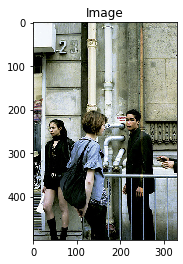

(17, 230)
Predicted Caption:-> A man in a blue hard a ropes dancing safety lot sunlight outdoors men beige . 
Orignal Caption:-> A man in a blue hard hat and orange safety vest stands in an intersection while holding a flag . 


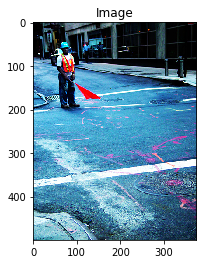

(10, 230)
Predicted Caption:-> Some women are standing in front of black . 
Orignal Caption:-> Some women are standing in front of a bus with buildings behind it . 


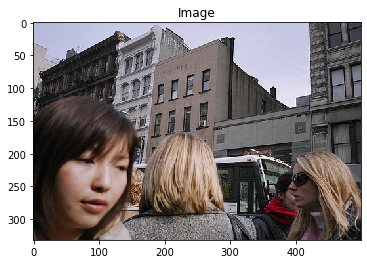

(14, 230)
Predicted Caption:-> Five ballet dancers caught mid jump in a while spots are yard . 
Orignal Caption:-> Five ballet dancers caught mid jump in a dancing studio with sunlight coming through a window . 


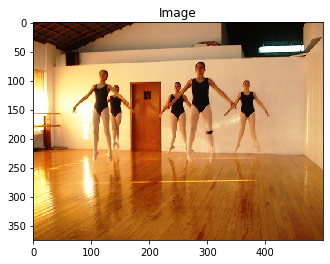

(19, 230)
Predicted Caption:-> A young woman with dark young a is at on , protection of with at boy system . 
Orignal Caption:-> A young woman with dark hair and wearing glasses is putting white powder on a cake using a sifter . 


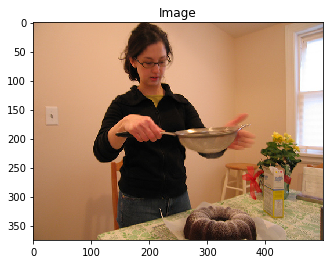

(50, 230)
Predicted Caption:-> The man with pierced ears out wearing the stands an the sifter . stair ropes system of rainbow place paintings , clarinets boy stands playing ropes giant it the standing the top outdoors without bus place their woman both rail looks large sneakers marketplace coming , camera system is 
Orignal Caption:-> The man with pierced ears is wearing glasses and an orange hat . 


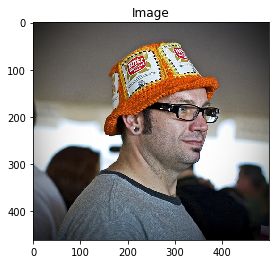

(10, 230)
Predicted Caption:-> Some women are standing in front of black . 
Orignal Caption:-> Some women are standing in front of a bus with buildings behind it . 


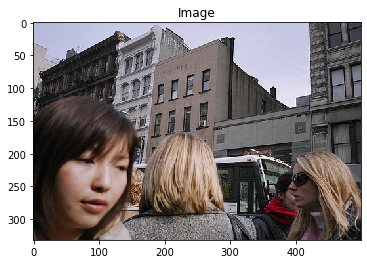

(10, 230)
Predicted Caption:-> Some women are standing in front of black . 
Orignal Caption:-> Some women are standing in front of a bus with buildings behind it . 


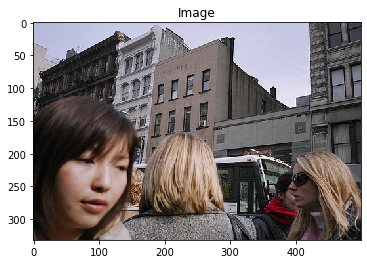

(14, 230)
Predicted Caption:-> Five ballet dancers caught mid jump in a while spots are yard . 
Orignal Caption:-> Five ballet dancers caught mid jump in a dancing studio with sunlight coming through a window . 


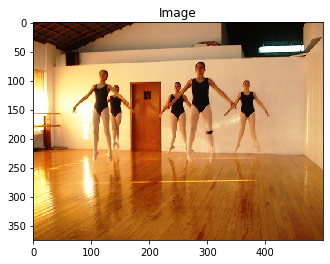

(18, 230)
Predicted Caption:-> A man in playing white t-shirt looks toward wearing time dress practicing , giant toothpick rail . 
Orignal Caption:-> A man in a white t-shirt looks toward the camera surrounded by a crowd near a metro station . 


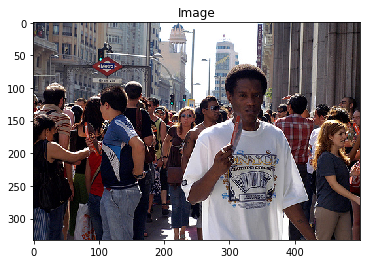

(16, 230)
Predicted Caption:-> Two people in the photo are playing type guitar with , writing stair waste . 
Orignal Caption:-> Two people in the photo are playing the guitar and the other is poking at him . 


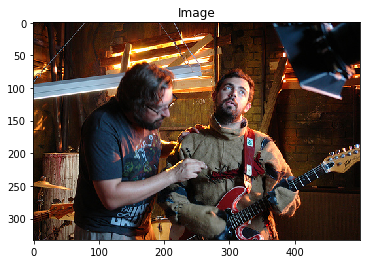

(35, 230)
Predicted Caption:-> A small child grips onto the red ropes at chair hat a black on flight near a of at dog is system red vest top in a other suit playground woman by outside front 
Orignal Caption:-> A small child grips onto the red ropes at the playground . 


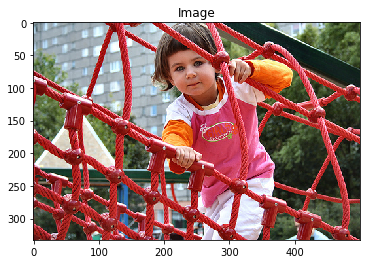

In [46]:
with tf.Session() as sess:
    sess.run(init)
    saver.save(sess, "my_test_model", global_step=1000)

    m = len(train_caption)
    for epoch in range(training_iters):
        total_cost = 0
        total_acc = 0
        for i in range(m):
            _, cst, acc = sess.run([optimizer, cost, accuracy], feed_dict = {x_caption:train_caption[i][:-1].A, x_inp:train[i:i+1], y:train_caption[i][1:].A})
            total_cost += cst
            total_acc += acc
        if (epoch + 1) % display_step == 0:
            print('After ', (epoch + 1), 'iterations: Cost = ', total_cost / m, 'and Accuracy: ', total_acc * 100/ m , '%' )
    print('Optimization finished!')
    print("Let's check")
    for tests in range(num_tests):
        image_num = random.randint(0, sample_size - 1)
        caption = sess.run(final_prediction, feed_dict = {x_inp:train[image_num:image_num + 1]})
        print(caption.shape)
        caption = np.argmax(caption[:-1], 1)
        capt = ''
        for i in caption:
            capt += rev_dict[i] + ' '
        print('Predicted Caption:->', capt)
        orig_cap = np.argmax(train_caption[image_num:image_num + 1][0][1:-1].A, 1)
        orignalcaption = ''
        for i in orig_cap:
            orignalcaption += rev_dict[i] + ' '
        print('Orignal Caption:->', orignalcaption)
        plt.imshow(real_images[image_num])
        plt.title('Image')
        plt.show()